## 7.5 批量规范化

批量规范化可以使得能够训练一百层以上的网络

### 7.5.1 训练深层网络

对于批量为1的小批量进行批量规范化肯定是没用的，在应用批量规范化时，批量大小的选择可能比没有批量规范化更重要。

总的来说，用$\bm{x}\in\mathcal{B}$表示来自一个小批量的输入，批量规范化BN根据以下表达式转换：

$$
\rm{BN}(\bm{x})=\bm{\gamma}\odot\frac{\bm{x}-\hat{\bm{\mu}}_\mathcal{B}}{\hat{\bm{\sigma}}_\mathcal{B}}+\bm{\beta}
$$

这包括了一些拉伸参数$\gamma$和偏移参数$\beta$，这是需要于其他模型参数一起训练的参数。

也就是说，**批量规范化是可以训练的**。

事实证明，优化过程中的各种噪声源通常会导致更快的训练和较少的过拟合：这种变化似乎是正则化的一种形式。

### 7.5.2 批量规范化层

#### 7.5.2.1 全连接层

通常将全连接层的批量规范化置于仿射变换和激活函数之间。

#### 7.5.2.2 卷积层

对于样本数$m$，卷积输出高度$p$和宽度$q$，批量规范化在**每个输出通道**上独立且同时对$m\cdot p\cdot q$个元素执行，也就是会收集某个通道上所有空间位置元素的值，而不是某个通道的某个位置的值。

#### 7.5.2.3 预测过程中的批量规范化

一种常用方法是通过移动平均估计整个数据集的样本均值和方差。在预测和训练上的计算结果也是不一样的。

### 7.5.3 从零实现

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

def batch_norm(X, gamma, beata, moving_mean, moving_bar, eps, momentum):
    """批次正则化"""
    # 通过is_grad_enabled来判断当前是预测模式还是训练模式
    if not torch.is_grad_enabled():
        # 如果是在预测模式下，直接使用传入的移动平均所得的均值和方差
        X_hat = (X - moving_mean) / torch.sqrt(moving_bar + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # 也就是全连接层的情况，计算均值和方差
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else: 
            # 也就是使用卷积层的情况，计算均值和方差
            mean = X.mean(dim=(0, 2, 3), keepdim=True)  # 不计算通道
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        # 训练模式下，使用当前的均值和方差
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # 更新移动平均的均值和方差
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_bar = momentum * moving_bar + (1.0 - momentum) * var
    Y = gamma * X_hat + beata  # 伸缩和偏移
    return Y, moving_mean, moving_bar

下面创建一个正确的BatchNorm层

In [2]:
class BatchNorm(nn.Module):
    """批次正则化层"""

    def __init__(self, num_features, num_dims):
        """
        num_fratures: 全连接层的输出数量或卷积层的输出通道数
        num_dims: 2表示全连接层，4表示卷积层
        """
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # 参与求梯度和迭代的拉伸和偏移参数，分别初始化为0和1，每个通道一个数
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # 非模型参数的变量初始化为0和1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)
    
    def forward(self, X):
        # 如果X不在内存上，将moving_mean和moving_var复制到X所在显存上
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # 保存更新过的moving_mean和moving_var
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean, self.moving_var,
            eps=1e-5, momentum=0.9)
        return Y

### 7.5.4 使用批量规范化层的LeNet

需要记住的是其在卷积层和全连接层之后，相应的激活函数之前应用的。

In [3]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), BatchNorm(16, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16*4*4, 120), BatchNorm(120, num_dims=2), nn.Sigmoid(),
    nn.Linear(120, 84), BatchNorm(84, num_dims=2), nn.Sigmoid(),
    nn.Linear(84, 10),
)

还是使用一样的训练方法

loss 0.265, train acc 0.903, test acc 0.827
38833.7 examples/sec on cuda:0


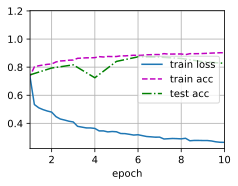

In [4]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

下面观察学习到的拉伸参数`gamma`和偏移参数`beta`。

In [5]:
net[1].gamma.reshape((-1,)), net[1].beta.reshape((-1,))

(tensor([4.1048, 1.9217, 2.8629, 1.9623, 3.0743, 1.5649], device='cuda:0',
        grad_fn=<ViewBackward0>),
 tensor([-2.5790, -2.2668,  3.0913,  0.5661,  1.4803, -1.0280], device='cuda:0',
        grad_fn=<ViewBackward0>))

### 7.5.5 简明实现

也就是直接使用`nn.BatchNorm`。

In [7]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), nn.BatchNorm2d(6), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16*4*4, 120), nn.BatchNorm1d(120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.BatchNorm1d(84), nn.Sigmoid(),
    nn.Linear(84, 10),
)

由于高级API变体的封装更好，因此更快

loss 0.271, train acc 0.900, test acc 0.813
67843.6 examples/sec on cuda:0


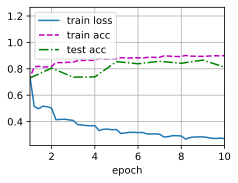

In [8]:
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

### 7.5.6 争议

也就是这个方法更加类似于直觉，没有什么太多的依据，但是整个深度学习的可解释性不都是不咋地吗？

### 7.5.7 小结

- 在模型训练过程中，批量规范化利用小批量的均值和标准差，不断调整神经网络的中间输出，使整个神经网络各层的中间输出值更加稳定。
- 批量规范化在全连接层和卷积层的使用略有不同。
- 批量规范化层和暂退层一样，在训练模式和预测模式下计算不同。
- 批量规范化有许多有益的副作用，主要是正则化。另一方面，”减少内部协变量偏移“的原始动机似乎不是一个有效的解释。